# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Define the objective and problem

In [2]:
# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                             grad=sp.optimize.rosen_der, 
                             hess=sp.optimize.rosen_hess)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

lb = -2 * np.ones((100,1))
ub = 2 * np.ones((100,1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

## Illustration

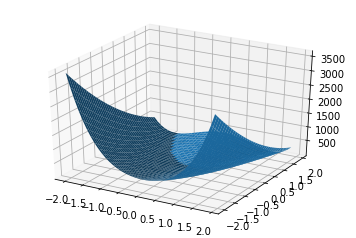

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)        

## Run optimization

In [4]:
optimizer = pypesto.ScipyOptimizer()
                                                                                                                                                                                                                                                                                                                                                                
result1 = pypesto.minimize(problem=problem1, optimizer=optimizer, n_starts=20)
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer, n_starts=20)

/home/yannik/yenv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/home/yannik/yenv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:513: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)


## Visualize and analyze results

pypesto offers easy-to-use visualization routines:

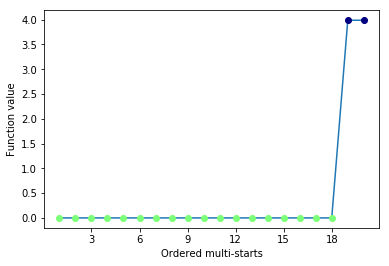

In [5]:
import pypesto.visualize

pypesto.visualize.waterfall(result1)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [6]:
result1.optimize_result.as_dataframe(['fval', 'n_fval', 'time'])

,fval,n_fval,time
0,1.065135e-10,599,0.167512
1,1.403094e-10,620,0.109558
2,1.621213e-10,611,0.096135
3,1.663359e-10,614,0.118495
4,1.681019e-10,584,0.110680
5,1.775510e-10,594,0.127146
6,2.383948e-10,620,0.099471
7,2.972560e-10,599,0.279744
8,3.155754e-10,594,0.095277
9,3.476706e-10,597,0.090982
